# day10: 2层 MLP on MNIST 架构搭建 

该notebook的实验均可以只用cpu运行。

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


`torchvixion.transforms`
- 格式统一： 不同的图像数据集可能有不同的格式（PIL Image, NumPy 数组等），模型训练需要统一的 - Tensor 格式。transform 可以把各种格式转成 PyTorch Tensor。
- 尺寸统一： 神经网络通常要求输入图像具有固定的尺寸，transform 可以帮你裁剪或缩放图像到指定大小。
- 数值归一化： 图像的像素值通常在 0-255 之间，需要缩放到一个模型更容易学习的范围（比如 0-1 或标准化到均值 0 方差 1）。transform 可以完成这些归一化操作。
- 数据增强 (Data Augmentation): 通过随机对图像进行一些变换（如翻转、旋转、裁剪、颜色抖动），可以人工增加训练集的多样性，让模型见过更多不同“姿势”或“光照”下的物体，从而提高模型的泛化能力，减少过拟合。transform 提供了丰富的增强操作。

In [7]:
# 定义数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) #mean,std
])

# 加载MNIST训练和测试集
train_dataset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='../data', train=False, download=True, transform=transform)

# 创建数据加载器
train_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

`Dataset`是pytorch的数据集类，自定义Dataset需要手动实现__getitem__(),__len__()方法。   
`DataLoader`是一个批次加载数据集到内存的迭代器。

一个批次的图像形状: torch.Size([64, 1, 28, 28])
一个批次的标签形状: torch.Size([64])


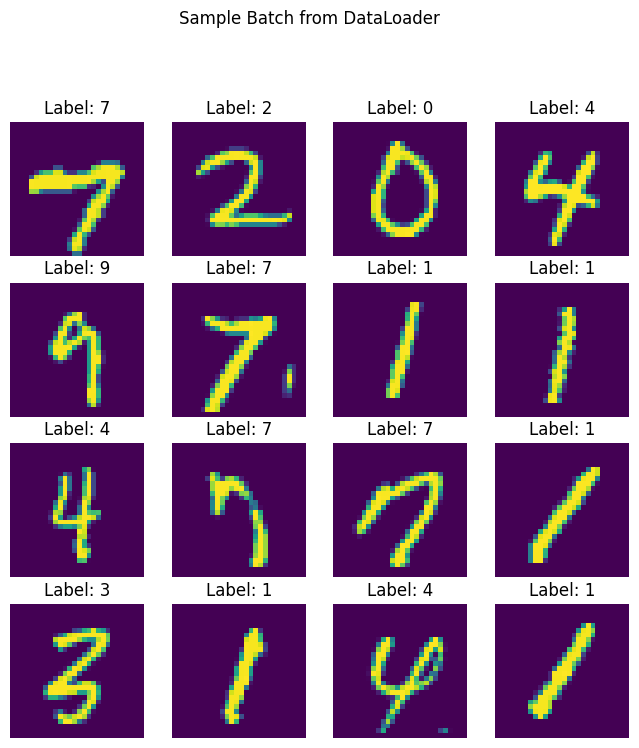

In [ ]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f"一个批次的图像形状: {images.shape}") # [batch_size, channels, height, width]
print(f"一个批次的标签形状: {labels.shape}") # [batch_size]

plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    img = images[i].squeeze(0) * 0.5 + 0.5 # 反归一化
    plt.imshow(img.numpy())
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.suptitle("Sample Batch from DataLoader")
plt.show()


In [11]:
class Mlp (nn.Module):
    def __init__(self):
        super(Mlp, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28) # 展平
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = Mlp().to(device)
print(model)

Mlp(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
epochs = 50
lr = 0.01
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

print('开始训练') 
for epoch in range(epochs):
    model.train()
    for _, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        output = model(data)
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    if(epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
print("训练完成！")

开始训练
Epoch [10/50], Loss: 0.0715
Epoch [20/50], Loss: 0.0528
Epoch [30/50], Loss: 0.0250
Epoch [40/50], Loss: 0.0530
Epoch [50/50], Loss: 0.0495
训练完成！


loss在30之后反而增加。过拟合，需要使用early-stopping。见day11.

In [14]:
model.eval()
with torch.no_grad(): 
    correct = 0
    total = 0
    for images, labels in test_loader:
        
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        
        # torch.max 返回值和索引，我们只需要索引 (索引就是预测的类别)
        _, predicted = torch.max(outputs.data, 1) # outputs.data 和 outputs 差不多，但更明确不跟踪梯度

        total += labels.size(0) # 累加样本总数
        correct += (predicted == labels).sum().item() # 累加正确预测的数量

    accuracy = 100 * correct / total
    print(f'测试集上的准确率: {accuracy:.2f} %')

print("评估完成！")


测试集上的准确率: 97.76 %
评估完成！


预测返回值形状 torch.Size([1000])


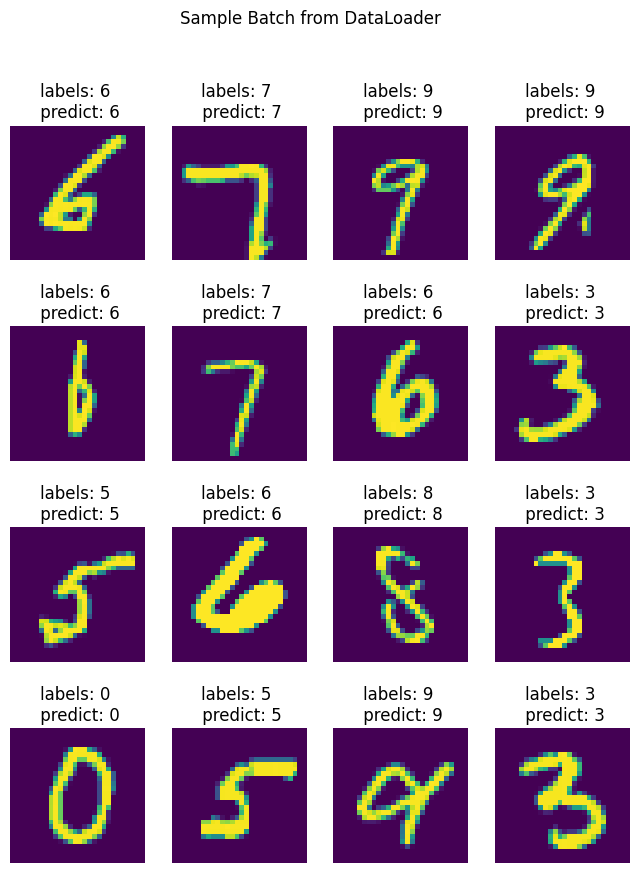

In [22]:
images, labels = next(data_iter)
predict = model(images)
print('预测返回值形状',predicted.shape)

plt.figure(figsize=(8, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    img = images[i].squeeze(0) * 0.5 + 0.5 # 反归一化
    plt.imshow(img.numpy())
    plt.title(f"labels: {labels[i].item()} \n predict: {predict[i].argmax().item()}")
    plt.axis('off')
plt.suptitle("Sample Batch from DataLoader")
plt.show()
